In [14]:
from pathlib import Path
import os

import numpy as np
from openslide import OpenSlide

from scellst.constant import PREDS_DIR
from sCellST_reproducibility.reproducibility_notebooks.utils_analyses import (
    load_visium,
    load_predictions,
    compute_deg,
    create_level_coordinates,
    crop_adata,
)
from sCellST_reproducibility.reproducibility_notebooks.utils_plot import plot_he, plot_marker_genes, plot_list_gene_image, plot_top_genes_2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Input
data_dir = Path("../../hest_data")
spot_adata_path = data_dir / "st" / "TENX65.h5ad"
wsi_path = data_dir / "wsis" / "TENX65.tif"
prediction_adata_path = PREDS_DIR / "exp" / "mil"  / "embedding_tag=moco-TENX65-rn50_train;genes=HVG:1000;train_slide=TENX65;test_slide=TENX65;infer_mode=inference.h5ad"

# Output
save_path = Path("figures/ovary")
save_path.mkdir(exist_ok=True)

In [16]:
# Load data
spot_adata = load_visium(spot_adata_path)
cell_adata = load_predictions(prediction_adata_path)
wsi = OpenSlide(wsi_path)

/home/loic/miniconda3/envs/CellST/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/tmp/ipykernel_7236/3271428540.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  spot_adata.obs["in_tissue"] = spot_adata.obs["in_tissue"].astype("category")


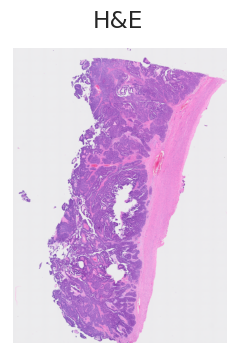

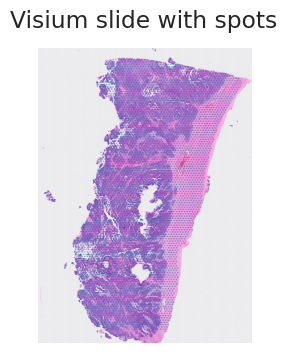

In [17]:
# HE
spot_adata = spot_adata[(spot_adata.obsm["spatial"][:, 0] > 0)]
plot_he(spot_adata, title="H&E", save_path=os.path.join(save_path, "he.png"))
spot_adata.obs["in_tissue"] = spot_adata.obs["in_tissue"].astype("category")
plot_he(
    spot_adata,
    title="Visium slide with spots",
    save_path=os.path.join(save_path, "he_spot.png"),
    obs_color="in_tissue",
)

Computing deg...
Plotting deg...


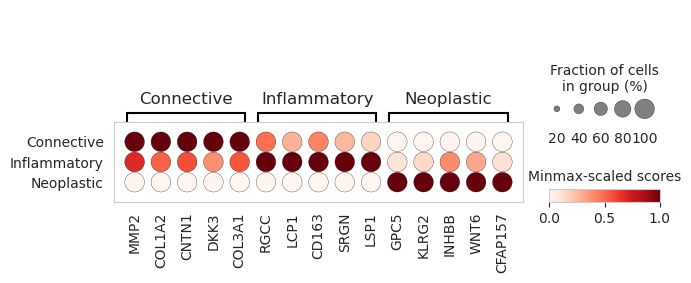

In [18]:
# DEG plots
compute_deg(cell_adata, "class")
list_deg_genes = plot_marker_genes(
    cell_adata,
    "class",
    save_path,
)

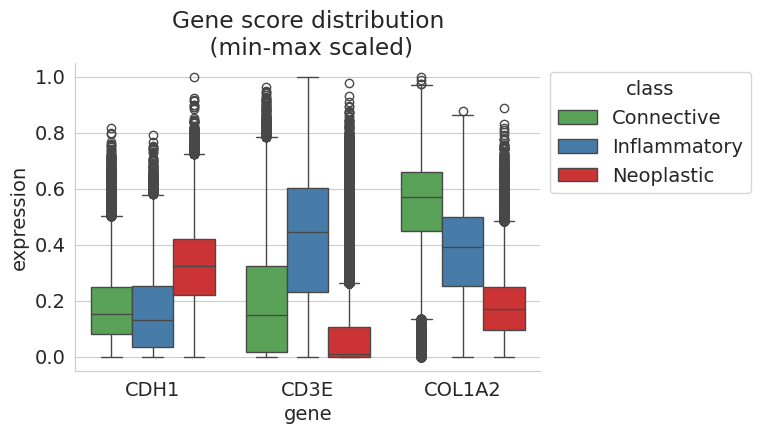

In [19]:
list_genes_to_plot = ["CDH1", "CD3E", "COL1A2"]
plot_top_genes_2(
    cell_adata,
    "class",
    list_genes_to_plot,
    save_path,
)

/home/loic/PycharmProjects/CellST/reproducibility_notebooks/utils_analyses.py:161: ImplicitModificationWarning: Setting element `.obsm['spatial_0']` of view, initializing view as actual.
  crop_adata.obsm["spatial_0"] -= np.asarray([x_min, y_min])


  0%|          | 0/6540 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/6540 [00:00<?, ?it/s]

  0%|          | 0/6540 [00:00<?, ?it/s]

  0%|          | 0/6540 [00:00<?, ?it/s]

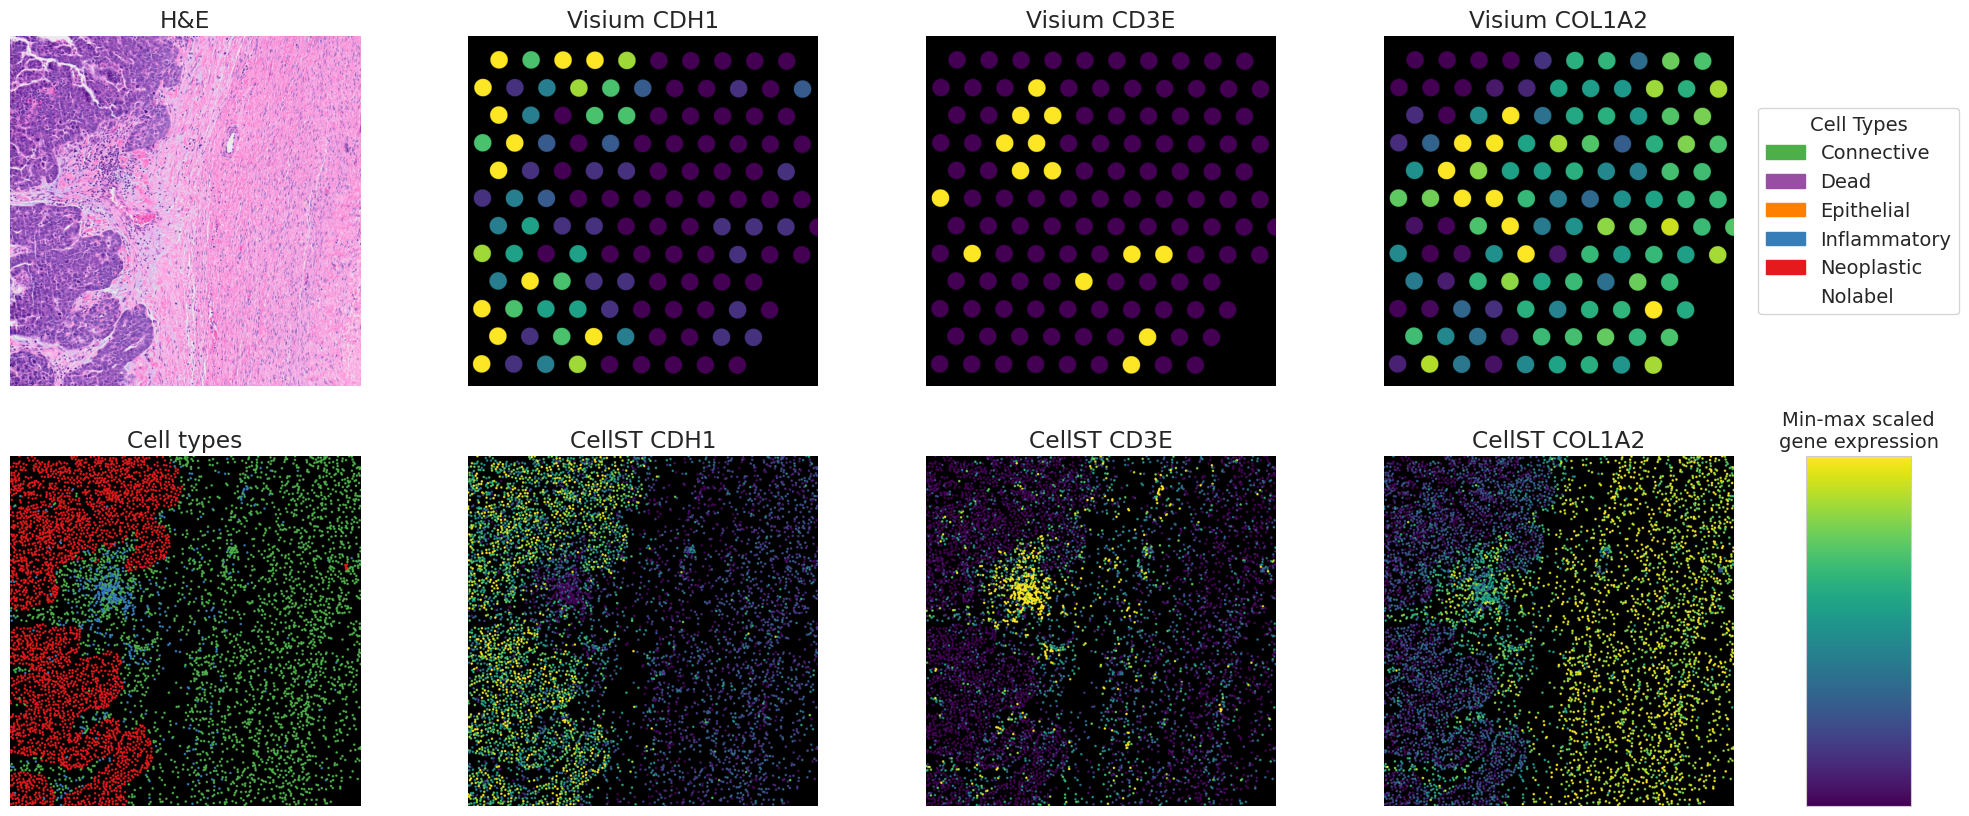

In [20]:
# Crop level
list_crop_coords = [(16000, 25000)]
crop_size = 4000
create_level_coordinates(spot_adata, img_level=0)
create_level_coordinates(cell_adata, img_level=0)
for i, crop_coord in enumerate(list_crop_coords):
    crop_image = wsi.read_region(location=crop_coord, level=0, size=(crop_size, crop_size))
    crop_image = np.array(crop_image.convert("RGB"))
    crop_spot_adata = crop_adata(spot_adata, crop_coord, crop_size)
    crop_cell_adata = crop_adata(cell_adata, crop_coord, crop_size)
    plot_list_gene_image(
        crop_spot_adata,
        crop_cell_adata,
        crop_image,
        list_genes_to_plot,
        os.path.join(save_path, f"local_crops_{i}.png"),
        0,
    )

In [21]:
print(cell_adata.obs["class"].value_counts().sort_index().to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
class &  \\
\midrule
Connective & 68685 \\
Dead & 105 \\
Epithelial & 60 \\
Inflammatory & 19618 \\
Neoplastic & 221455 \\
\bottomrule
\end{tabular}

